In [41]:
library(aws.signature)
library(aws.s3)
library(tree)
library(colorspace)

use_credentials(profile = "handson2", file = "./credentials")
# Sys.getenv()

In [30]:
rgb = read.csv('rgb.csv')
head(rgb)

NAME,COL,R,G,B,LABEL,SOURCE
RAL 1000,#ccc58f,204,197,143,yellow,REFERENCE
RAL 1001,#d1bc8a,209,188,138,yellow,REFERENCE
RAL 1002,#d2b773,210,183,115,yellow,REFERENCE
RAL 1003,#f7ba0b,247,186,11,yellow,REFERENCE
RAL 1004,#e2b007,226,176,7,yellow,REFERENCE
RAL 1005,#c89f04,200,159,4,yellow,REFERENCE


In [31]:
# 컬림 설명
# NAME: 이름
# COL: 헥사로 표현된 RGB 정보
# R: Red [0-255]
# G: Green [0-255]
# B: Blue [0-255]
# LABEL: 분류 된 색상 정보
# SOURCE: 해당 데이터의 출처 정보
# - REFERENCE: https://en.wikipedia.org/wiki/List_of_RAL_colors
# - PRODUCT: 상품이미지에서 추출한 대표 색상정보
str(rgb)

'data.frame':	2808 obs. of  7 variables:
 $ NAME  : Factor w/ 2808 levels "1","10","100",..: 2596 2597 2598 2599 2600 2601 2602 2603 2604 2605 ...
 $ COL   : Factor w/ 2456 levels "#000000","#005d4c",..: 1557 1638 1650 2337 1879 1449 1852 2013 1096 1721 ...
 $ R     : int  204 209 210 247 226 200 225 231 175 217 ...
 $ G     : int  197 188 183 186 176 159 161 156 138 192 ...
 $ B     : int  143 138 115 11 7 4 0 0 84 34 ...
 $ LABEL : Factor w/ 10 levels "black","blue",..: 10 10 10 10 10 10 10 10 10 10 ...
 $ SOURCE: Factor w/ 2 levels "PRODUCT","REFERENCE": 2 2 2 2 2 2 2 2 2 2 ...


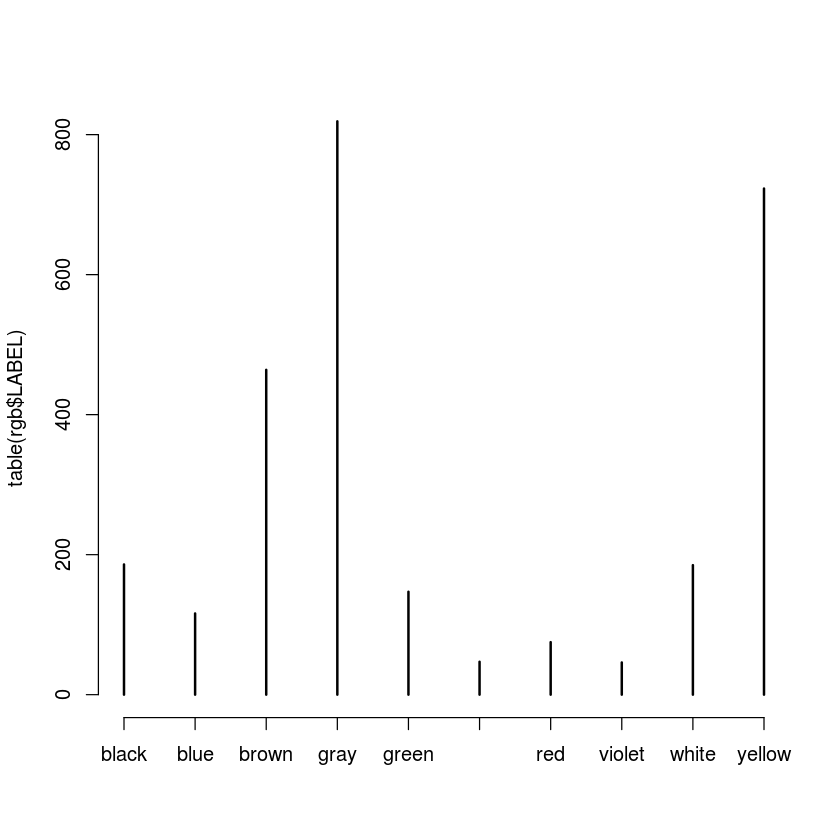

In [32]:
plot(table(rgb$LABEL))

In [33]:
dat = rgb[, c("R", "G", "B", "LABEL")]
col.type = "rgb"

# col.type = "lab"
# lab = as(RGB(dat[, "R"]/255, dat[, "G"]/255, dat[, "B"]/255), "LAB")
# dat = as.data.frame(coords(lab))
# dat$LABEL = rgb$LABEL

set.seed(0908)
index = sample(round(nrow(dat) * 0.7))

# 훈련 데이터와 평가 데이터를 분리
train.dat = dat[index, ]
test.dat = dat[-index, ]

write.csv(train.dat, file = "train.csv")
write.csv(test.dat, file = "test.csv")

In [34]:
bucket.name = "sagemaker-handson-2"
result = try(bucket_exists(bucket.name),
                  silent = F)
if(!result[1]) {
  put_bucket(bucket.name)  
}

# 원본 데이터, 학습 데이터, 평가 데이터를 S3에 업로드
put_object(file = "rgb.csv", bucket = bucket.name)
put_object(file = "train.csv", bucket = file.path(bucket.name, "data", col.type, "train"))
put_object(file = "test.csv", bucket = file.path(bucket.name, "data", col.type, "test"))

[1] TRUE

[1] TRUE

[1] TRUE

In [35]:
# tree 모델을 학습 데이터로 학습
model = tree(LABEL ~ ., data = train.dat)
summary(model)


Classification tree:
tree(formula = LABEL ~ ., data = train.dat)
Number of terminal nodes:  18 
Residual mean deviance:  0.6737 = 1312 / 1948 
Misclassification error rate: 0.1068 = 210 / 1966 

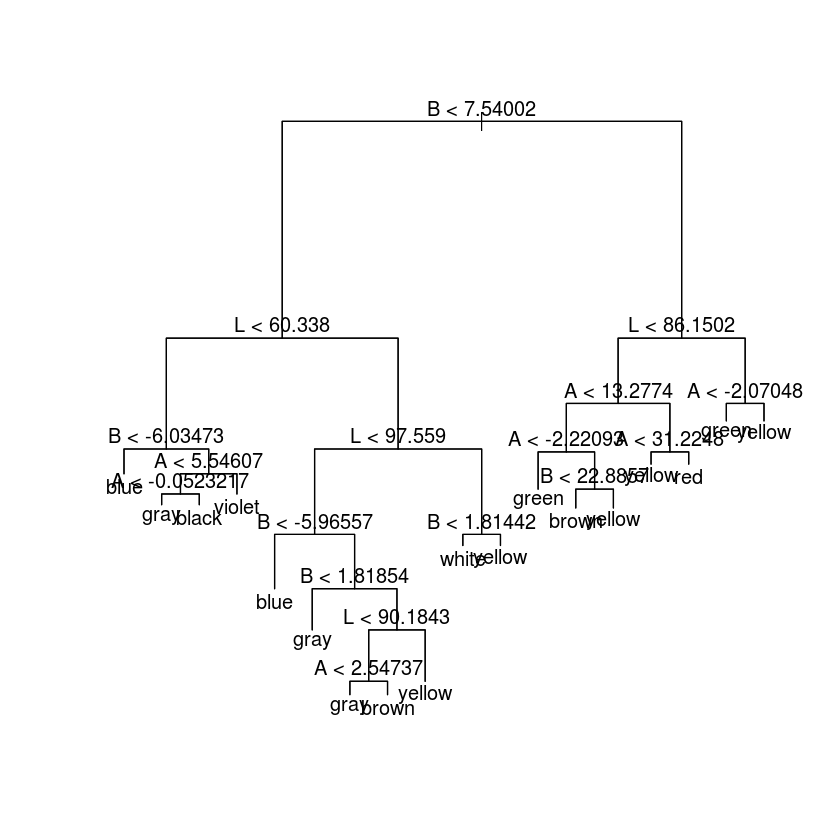

In [36]:
# 시각화
plot(model); text(model)

In [37]:
# 평가 데이터를 이용해서 모델 검증하기
result = predict(model, test.dat)
# colnames(result)[apply(result, 1, which.max)]
# table(test.dat$LABEL == colnames(result)[apply(result, 1, which.max)])

# Confusion Matrix
table(test.dat$LABEL, colnames(result)[apply(result, 1, which.max)])

        
         black blue brown gray green red violet white yellow
  black     45    0     0    2     0   0      0     0      0
  blue       0   31     0    0     0   0      0     0      0
  brown      0    0   133    2     0   0      0     0      5
  gray       1    0     1  251     0   0      0     0      0
  green      9    0     0    0    26   0      0     0      1
  orange     0    0     0    0     0  12      0     0      0
  red        0    0     0    0     0  12      0     0      0
  violet     0    0     0    0     0   0      8     0      0
  white      0    0     0    0     0   0      0    61      0
  yellow     0    0     2    0     1   0      0     0    239

In [38]:
save(model, file = "model.Rdata")
system("tar -cvzf model.tar.gz model.Rdata")

# 학습 한 모델을 S3에 업로드
# 향후에 새로운 데이터를 입력하여 예측을 할 때 사용
put_object(file = "model.tar.gz", bucket = file.path(bucket.name, "model"))

[1] TRUE